In [285]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.stats import norm
from numba import njit

Container classes for Underlying and Option parameters
Functions for boundary conditions and calculations

In [286]:
class Underlying:
    def __init__(self,
                 price: float,
                 volatility: float,
                 interest=0.0):
        self.price = price
        self.interest = interest
        self.volatility = volatility

class Option:
    def __init__(self,
                 underlying: Underlying,
                 style: str,
                 call: bool,
                 strike: float,
                 maturity=1.0):
        self.Underlying = underlying
        self.style = style
        self.call = call
        self.strike = strike
        self.maturity = maturity
        self.value = None

def put_bounds(q, t, x):
    return np.exp(t * (q + 1)**2 / 4) * max(0, np.exp((q - 1)*x/2) - np.exp((q + 1)*x/2))

def call_bounds(q, t, x):
    return np.exp((q + 1)**2 * t/4) * max(0, np.exp((q + 1)*x/2) - np.exp((q - 1)*x/2))

def bsm(s_array: list, t_array: list, K, T, r, vol, call=True):
    m = len(s_array)
    n = len(t_array)
    V = np.empty((m,n))
    p = 1 if call else -1

    for i in np.arange(1, n):
        for j in np.arange(m):
            t = t_array[i]
            S = s_array[j]
            D1 = (np.log(S / K) + (vol ** 2 / 2 + r) * (T - t)) / (vol * np.sqrt(T - t))
            D2 = (np.log(S / K) + (-vol ** 2 / 2 + r) * (T - t)) / (vol * np.sqrt(T - t))
            V[j, i] = p * S * norm.cdf(p * D1) - p * K * np.exp(r * (t - T)) * norm.cdf(p * D2)
    for j in range(m):
        V[j, 0] = max(p*(s_array[j] - K), 0)
    return V

@njit
def scalar_walk(A, B):
    """
    three-dots scalar walk algorythm for solving Linear systems with bidiagonal matrix
    :param A: bidiagonal matrix
    :param B: array
    :return: solution for system A*x=B
    """
    # scalar walk coefficients (forward walk)
    f = -B
    n = len(A)
    P = np.zeros(n-1)
    Q = np.zeros(n)
    P[0] = -1*A[0][1]/A[0][0]
    Q[0] = -1*f[0]/A[0][0]
    for i in range(1, n):
        a = A[i][i-1]
        c = -1*A[i][i]
        if i != n-1:
            b = A[i][i+1]
            P[i] = b/(c-a*P[i-1])
        Q[i] = (f[i]+a*Q[i-1])/(c-a*P[i-1])

    # (backward walk)
    x = np.zeros(n)
    x[n-1] = Q[n-1]
    for i in range(n-2, -1, -1):
        x[i] = P[i]*x[i+1]+Q[i]
    return x

Creating $Grid$ class for Grid creation and plotting

In [287]:
class Grid:
    """""
    It is assumed that parameters of the grid are set as for Heat Equation.
    """""

    def __init__(self, xSteps: int, tSteps: int, xLeft=-3.0, xRight=3.0):
        self.heatEquationFlag = True
        self.xSteps = xSteps
        self.tSteps = tSteps
        self.xLeft = xLeft
        self.xRight = xRight
        self.option = None

        self._net = np.zeros((self.xSteps + 1, self.tSteps + 1))
        self.xGrid = np.linspace(self.xLeft, self.xRight, self.xSteps + 1)
        self.timeBorder = None
        self.tGrid = None
        self.dx = None
        self.dt = None
        self.lamda = None
        self.q = None

    def _createGrid(self):
        self.timeBorder = self.option.maturity * np.square(self.option.Underlying.volatility) / 2
        self.tGrid = np.linspace(0, self.timeBorder, self.tSteps + 1)
        self.dx = (self.xRight - self.xLeft) / self.xSteps
        self.dt = self.timeBorder / self.tSteps
        self.lamda = self.dt / np.square(self.dx)
        self.q = 2 * self.option.Underlying.interest / np.square(self.option.Underlying.volatility)

    def addOption(self, option: Option):
        self.option = option
        self._createGrid()

    @property
    def net(self):
        return self._net

    @net.setter
    def net(self, external_net):
        if self._net.shape != (self.xSteps + 1, self.tSteps + 1):
            print(f'Warning: unexpected size of net {np.size(self.net)} instead of {(self.xSteps + 1, self.tSteps + 1)}')
        self._net = external_net

    # TODO: add stopping line execution
    # TODO cmpare to bsm and plt difference

    def fill_bsm(self):
        K = self.option.strike
        vol = self.option.Underlying.volatility
        r = self.option.Underlying.interest
        T = self.option.maturity

        if self.heatEquationFlag:
            self.tGrid = np.array([T - 2 * t / np.square(vol) for t in self.tGrid])
            self.xGrid = np.array([K * np.exp(x) for x in self.xGrid])
            self.heatEquationFlag = False

        values = bsm(self.xGrid, self.tGrid, K, T, r, vol, self.option.call)
        self._net = values

    def setBoundsPut(self):
        q = self.q
        for i in np.arange(self.tSteps + 1):
            self.net[self.xSteps, i] = put_bounds(q, self.tGrid[i], self.xGrid[-1])
            self.net[0, i] = put_bounds(q, self.tGrid[i], self.xGrid[0])
        for i in np.arange(self.xSteps + 1):
            self.net[i, 0] = put_bounds(q, self.tGrid[0], self.xGrid[i])

    def asymptotic_stopping_line(self):
        curve = [self.option.strike]
        for i in range(1,len(self.tGrid)):
            t = self.tGrid[i] - self.option.maturity
            stop_price = self.option.strike * (1 - self.option.Underlying.volatility*np.sqrt(t * np.log(-t)))
            curve.append(stop_price)
        return curve

    def transform(self, obj_mutation=True): # TODO: add inverse transform
        K = self.option.strike
        vol = self.option.Underlying.volatility
        T = self.option.maturity

        if self.heatEquationFlag:
            tmpNet = self.net.copy()
            for n in np.arange(len(self.tGrid)):
                for k in np.arange(len(self.xGrid)):
                    tmpNet[k, n] = K * np.exp((1 - self.q) * self.xGrid[k] / 2 - (((self.q + 1) ** 2) / 4) * self.tGrid[n]) * tmpNet[k, n]
            t_array = np.array([T - 2 * t / np.square(vol) for t in self.tGrid])
            S_array = np.array([self.option.strike * np.exp(x) for x in self.xGrid])

            self.heatEquationFlag = False
            if obj_mutation:
                self.xGrid = S_array
                self.tGrid = t_array
                self.net = tmpNet
        else:
            if not obj_mutation:
                return self.xGrid.copy(), self.tGrid.copy(), self.net()

    def plot(self, slice_num=0, cut=False, stoppingline=False):
        """ plotting 3D graph and slices by time """
        K = self.option.strike
        r = self.option.Underlying.interest
        T = self.option.maturity
        tempNet = self.net
        tempXgrid = self.xGrid
        if cut:
            leftBorder = K * 0.15
            rightBorder = K * 3
            leftBorder = np.where(self.xGrid < leftBorder)[0][-1]
            rightBorder = np.where(self.xGrid > rightBorder)[0][0]
            tempNet = self.net[leftBorder:rightBorder, :]
            tempXgrid = self.xGrid[leftBorder:rightBorder]
        if slice_num == 0:
            surface = go.Surface(z=tempNet, x=self.tGrid, y=tempXgrid)
            if stoppingline:
                stop_curve = self.asymptotic_stopping_line()
                curve = go.Scatter3d(z= 10*np.ones(len(stop_curve)), x=self.tGrid, y=stop_curve, mode="markers", marker=dict(size=3,color="green"))
                fig = go.Figure([surface, curve])
            else:
                fig = go.Figure([surface])
            fig.update_layout(title='V(S,t)', autosize=False, width=800, height=500, margin=dict(l=65, r=50, b=65, t=90))
            fig.show()
        else:
            plt.style.use("Solarize_Light2")
            plt.figure(figsize=(15, 8))
            for i in np.linspace(0, len(self.tGrid) - 1, slice_num):
                plt.plot(tempXgrid, tempNet[:, int(i)], label=f"t = {self.tGrid[int(i)]}")
            if stoppingline:
                stop_curve = self.asymptotic_stopping_line()
                for i in np.linspace(0, len(self.tGrid) - 1, slice_num):
                    plt.axvline(stop_curve[int(i)], color='green')
            plt.legend()
            plt.show()

### Valuation of European options with finite differences
$$
\frac{\partial V}{\partial t}+\frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2}+rS \frac{\partial V}{\partial S}-r V=0
$$

The Black-Scholes equation can be reduced to Heat equation by replacing variables as shown below.

$$
\begin{aligned}
&V(S, t)=V\left(K \mathrm{e}^x, T-\frac{2 \tau}{\sigma^2}\right)=: v(x, \tau) \\
&v(x, \tau)=K \exp \left\{-\frac{1}{2}\left(q-1\right) x-\left(\frac{1}{4}\left(q+1\right)^2\right) \tau\right\} y(x, \tau)
\end{aligned}
$$

$$
\frac{\partial y}{\partial \tau}=\frac{\partial^2 y}{\partial x^2}
$$

Heat equation is useful, because we can solve it numerically and then transform the solution to normal variables.
Here Crank-Nickolson Scheme is used:

+ Constructing matricies ($where\ \lambda=\frac{\Delta \tau}{\Delta x^2}$)
$$
A=\left(\begin{array}{cccc}
1+\lambda & -\frac{\lambda}{2} & & 0 \\
-\frac{\lambda}{2} & \ddots & \ddots & \\
& \ddots & \ddots & -\frac{\lambda}{2} \\
0 & & -\frac{\lambda}{2} & 1+\lambda
\end{array}\right), \quad B=\left(\begin{array}{cccc}
1-\lambda & \frac{\lambda}{2} & & 0 \\
\frac{\lambda}{2} & \ddots & \ddots & \\
& \ddots & \ddots & \frac{\lambda}{2} \\
0 & & \frac{\lambda}{2} & 1-\lambda
\end{array}\right)
$$

+ starting computation from the Payoff:
+ for $\nu=0,1, \ldots, \nu_{\max }-1:\ (steps\ by\ time)$
$$c=B w^{(\nu)} \quad$$
$$Solve\ system\ A x=c \quad$$
$$w^{(\nu+1)}=x$$

In [288]:
# setting the underlying
stock = Underlying(price=65,
                   volatility=0.3,
                   interest=0.01)

# creating the European Put option
EuPut = Option(underlying=stock, style="European", call=False, strike=50)

# creating the grid and adding option's parameters
grid0 = Grid(xSteps=300, tSteps=200, xLeft=-3.0, xRight=3.0)
grid0.addOption(EuPut)
# setting boundary conditions for put option
grid0.setBoundsPut()

In [289]:
net = grid0.net
q = grid0.q
n = grid0.xSteps
c = grid0.lamda

# creating matrices for schemes
A = np.diag(np.ones(n + 1) * (1 + c))
B = np.diag(np.ones(n + 1) * (1 - c))
for i in range(1, n + 1):
    A[i, i - 1] = -c / 2
    A[i - 1, i] = -c / 2
    B[i, i - 1] = c / 2
    B[i - 1, i] = c / 2
# TODO: remove below
A[0,0] = 1
A[n,n] = 1
A[0,1] = 0
A[n,n-1] = 0
B[0,0] = 1
B[n,n] = 1
B[0,1] = 0
B[n,n-1] = 0

# crank-nickolson scheme
for i in np.arange(0, grid0.tSteps):
    # explicit step
    f = np.dot(B, net[:, i])
    # implicit step
    solution = scalar_walk(A, f)
    net[:, i + 1] = solution

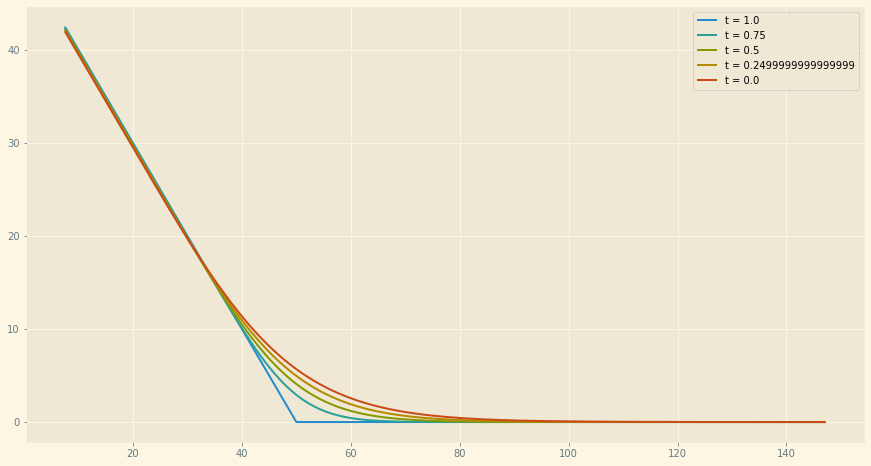

In [290]:
%matplotlib inline
grid0.net = net
grid0.transform()
grid0.plot(0, cut=True)
grid0.plot(5, cut=True)

### American option problem
Such approach can be used for valuation of American options.
However, it is more difficult because option can be exercised at any time.

In this situation we have to solve a system with inequalities instead of one equation:
$$
\left.\begin{array}{r}
\left(\frac{\partial y}{\partial \tau}-\frac{\partial^2 y}{\partial x^2}\right)(y-g)=0 \\
\frac{\partial y}{\partial \tau}-\frac{\partial^2 y}{\partial x^2} \geq 0 \\
y-g \geq 0
\end{array}\right\}
$$
For this type of problem we should use Brennan-Schwarz algorithm.

In [291]:
# creating the American Put option
AmPut = Option(underlying=stock,
               style="American",
               call=False,
               strike=50)

# creating the grid and adding option's parameters
grid = Grid(xSteps=300,
            tSteps=200,
            xLeft=-3.0,
            xRight=3.0)
grid.addOption(AmPut)
# setting boundary conditions
grid.setBoundsPut()
net = grid.net

### Implementing Brennan-Schwarz algorythm

The algorithm is based on a Gaussian elimination where the early
exercise constraint is handled in a simple manner.
At each time step $\nu$, the problem needs to be solved:
$$
\left\{\begin{array}{c}
\boldsymbol{A} \boldsymbol{y}^{(\nu+1)} \geq \boldsymbol{b}^{(\nu)} \\
\boldsymbol{y}^{(\nu+1)} \geq \boldsymbol{g} \\
\left(\boldsymbol{A} \boldsymbol{y}^{(\nu+1)}-\boldsymbol{b}^{(\nu)}\right)^T\left(\boldsymbol{y}^{(\nu+1)}-\boldsymbol{g}\right)=0
\end{array}\right.
$$

The algorithm is the following: The Gaussian elimination transforms rows of the system of linear equations
$\boldsymbol{A} \boldsymbol{y}=\boldsymbol{b}$ to the form:
$$
p_i y_i+s_i y_{i+1}=k_i, \ \ \ (*)
$$
for $i=1, \ldots, m$, where the coefficients can be chosen to be
$$
\begin{gathered}
p_1=a_{11}, \quad s_1=a_{12}, \quad k_1=b_1 \\
p_i=a_{i i}-\frac{a_{i i-1}}{p_{i-1}} a_{i-1 i}, \quad s_i=a_{i i+1}, \quad k_i=b_i-\frac{a_{i i-1}}{p_{i-1}} k_{i-1} \\
p_m=a_{m m}-\frac{a_{m m-1}}{p_{m-1}} a_{m-1 m} \quad \text { and } \quad k_m=b_m-\frac{p_{m-1}}{a_{m m-1}} k_{m-1}
\end{gathered}
$$

The solution $y$ for the system of inequalities above is obtained by using the equation (*) and the payoff
function of the put option.
Starting by solving from i = m, if $y_m$ is less than the payoff value then set $y_m = g_m$. Then to solve $y_{m−1}$ and so on...

(Original algorythm can be found in the article:
M. J. Brennan and E. S. Schwartz, The valuation of American put options,
Journal of Finance, 32 (1977), pp. 449–462.)

In [292]:
@njit
def brennan_schwartz(alpha, beta, gamma, b, g):
    """""
    Solution to Ax-b >= 0 ; x >= g and (Ax-b)'(x-g)=0 ;

    A - bidiagonal matrix with alpha, beta, gamma coefficients
    alpha: [n x 1] numpy vector  of main diagonal of A
    beta: [(n-1) x 1] numpy vector of upper diagonal
    gamma: [(n-1) x 1] numpy vector of lower diagonal
    """""
    n = len(alpha)
    alpha_hat = np.zeros(n, dtype=np.float64)
    b_hat = np.zeros(n, dtype=np.float64)

    alpha_hat[-1] = alpha[-1]
    b_hat[-1] = b[-1]

    for i in range(n - 2, -1, -1):
        alpha_hat[i] = alpha[i] - beta[i] * gamma[i] / alpha_hat[i + 1]
        b_hat[i] = b[i] - beta[i] * b_hat[i + 1] / alpha_hat[i + 1]

    x = np.zeros(n, dtype=np.float64)
    x[0] = np.maximum(b_hat[0] / alpha_hat[0], g[0])
    for i in range(1, n):
        x[i] = np.maximum((b_hat[i] - gamma[i - 1] * x[i - 1]) / alpha_hat[i], g[i])
    return x

### Valuating American option via finite differences + Brennan-Schwarz algorythm

In [293]:
n = grid.xSteps
# matrix for explicit step
B = np.zeros((n + 1, n + 1))
for i in range(1, n + 1):
    B[i, i] = 1 - grid.lamda
    B[i, i - 1] = grid.lamda / 2
    B[i - 1, i] = grid.lamda / 2
B[0,0] = 1
B[n,n] = 1
B[0,1] = 0
B[n,n-1] = 0

# diagonals of the A matrix (implicit step):
alpha = (1 + grid.lamda) * np.ones(n+1)
alpha[0] = 1
alpha[-1] = 1
beta = -0.5 * grid.lamda * np.ones(n)
beta[0] = 0
gamma = -0.5 * grid.lamda * np.ones(n)
gamma[-1] = 0

# brennan-shwartz algorythm
for i in np.arange(0, grid.tSteps):
    # setting early execution curve
    time = grid.tGrid[i + 1]
    g = tuple(map(lambda x: put_bounds(grid.q, time, x), grid.xGrid))
    # explicit step
    # f_hat = net[:, i]
    # f_hat[0] = f_hat[0] + 0.5 * grid.lamda * (put_bounds(grid.q, grid.tGrid[i], grid.xGrid[0]) + g[0])
    f = np.dot(B, net[:, i])
    # implicit step
    solution = brennan_schwartz(alpha, beta, gamma, f, g)
    net[:, i + 1] = solution
grid.net = net

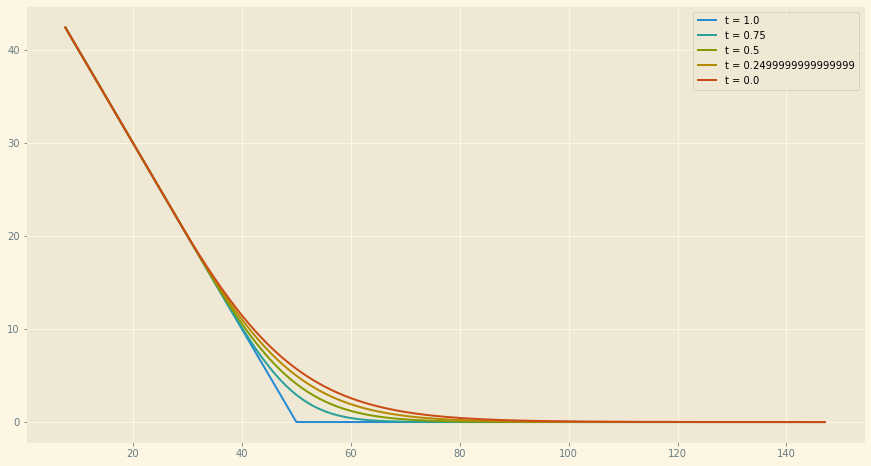

In [294]:
# transforming coordinates
grid.transform(True)
grid.plot(5, cut=True)

### Valuating European Put option with the same Underlying, Strike and Maturity

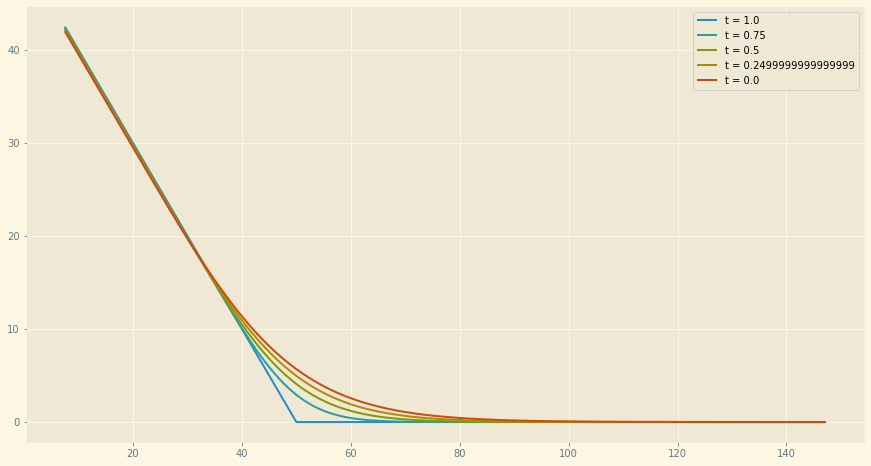

In [295]:
EuPut = Option(stock, "European", False, 50)
# creating the grid and adding option's parameters
grid2 = Grid(300, 200, -3.0, 3.0)
grid2.addOption(EuPut)
grid2.fill_bsm()
grid2.plot(5, cut=True)

### Plotting the difference between American and European

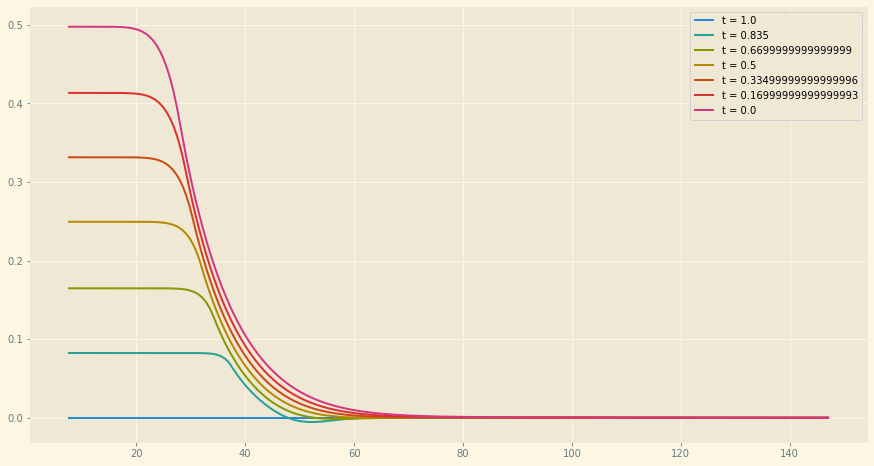

In [296]:
grid2.net = grid.net - grid2.net
grid2.plot(7, cut=True)